## Predicting hand written digits between 0 and 9 using the full MNIST Dataset

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 9.1 MB/s 
     |████████████████████████████████| 186 kB 45.5 MB/s 
     |████████████████████████████████| 1.2 MB 53.5 MB/s 
     |████████████████████████████████| 46 kB 3.5 MB/s 
     |████████████████████████████████| 56 kB 2.4 MB/s 
     |████████████████████████████████| 51 kB 289 kB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [3]:
path = untar_data(URLs.MNIST)
print(path)
Path.BASE_PATH = path

path

/root/.fastai/data/mnist_png


Path('.')

In [4]:
# examine all of the paths required
all_paths = (path/'training').ls()
all_paths

(#10) [Path('training/3'),Path('training/4'),Path('training/0'),Path('training/6'),Path('training/1'),Path('training/7'),Path('training/8'),Path('training/9'),Path('training/5'),Path('training/2')]

In [5]:
validation_paths = (path/'testing').ls()
validation_paths

(#10) [Path('testing/3'),Path('testing/4'),Path('testing/0'),Path('testing/6'),Path('testing/1'),Path('testing/7'),Path('testing/8'),Path('testing/9'),Path('testing/5'),Path('testing/2')]

In [6]:
get_tensors_from_path = lambda num, set_type: torch.stack([tensor(Image.open(file_url)) for file_url in (path/set_type/num).ls()]).float()/255

In [7]:
ones = get_tensors_from_path('1', 'training')
ones.shape

torch.Size([6742, 28, 28])

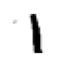

In [8]:
show_image(ones[0])

In [9]:
numbers = [str(i) for i in range(10)]
all_train_list = [get_tensors_from_path(number, 'training') for number in numbers]
all_valid_list = [get_tensors_from_path(number, 'testing') for number in numbers]

In [10]:
len(all_train_list), all_train_list[0].shape, all_train_list[1].shape

(10, torch.Size([5923, 28, 28]), torch.Size([6742, 28, 28]))

In [11]:
len(all_valid_list), all_valid_list[0].shape, all_valid_list[1].shape

(10, torch.Size([980, 28, 28]), torch.Size([1135, 28, 28]))

In [12]:
num_element_list = []
num_valid_elements = []
# test getting the number of each type of image in the training list
for i in range (len(all_train_list)):
  print("Num elements for", i, "is", all_train_list[i].shape[0])
  num_element_list.append(all_train_list[i].shape[0])
  num_valid_elements.append(all_valid_list[i].shape[0])

num_element_list, num_valid_elements

Num elements for 0 is 5923
Num elements for 1 is 6742
Num elements for 2 is 5958
Num elements for 3 is 6131
Num elements for 4 is 5842
Num elements for 5 is 5421
Num elements for 6 is 5918
Num elements for 7 is 6265
Num elements for 8 is 5851
Num elements for 9 is 5949


([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
 [980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009])

In [13]:
# create the training and validation sets
# reduce to 2D matrix 784 columns (one row per image)
train_x = torch.cat(all_train_list).view(-1, 28*28)

# make a list of tensors of corresponding target values, then concatenate tensors using unsqueeze
train_y = torch.cat([tensor([i]*num_element_list[i]) for i in range(len(num_element_list))]).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

In [14]:
# do the same for validaiton set
valid_x = torch.cat(all_valid_list).view(-1, 28*28)
valid_y = torch.cat([tensor([i]*num_valid_elements[i]) for i in range(len(num_valid_elements))]).unsqueeze(1)
valid_x.shape, valid_y.shape


(torch.Size([10000, 784]), torch.Size([10000, 1]))

(<matplotlib.image.AxesImage at 0x7fcf3db934d0>, tensor([0]))

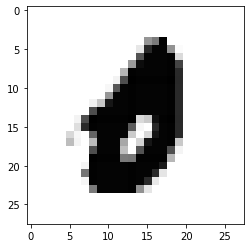

In [21]:
plt.imshow(train_x[0].view(28, 28)), train_y[0]

(<matplotlib.image.AxesImage at 0x7fcf3da71250>, tensor([0]))

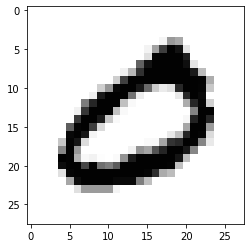

In [22]:
plt.imshow(train_x[1000].view(28, 28)), train_y[1000]

(<matplotlib.image.AxesImage at 0x7fcf3da58790>, tensor([1]))

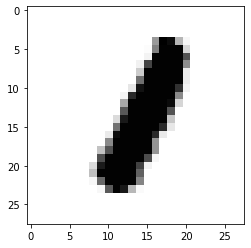

In [23]:
plt.imshow(train_x[10000].view(28, 28)), train_y[10000]

(<matplotlib.image.AxesImage at 0x7fcf3d7806d0>, tensor([8]))

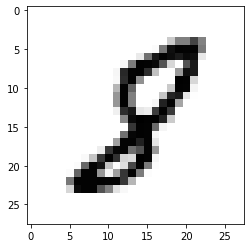

In [25]:
plt.imshow(train_x[50000].view(28, 28)), train_y[50000]

In [35]:
# the images seem correctly labelled, create two data loaders now - for training and validation sets
to_loader = lambda x, y, batch_size: DataLoader(list(zip(x, y)), batch_size=batch_size)

train_dl = to_loader(train_x, train_y, 256)
valid_dl = to_loader(valid_x, valid_y, 256)
first(train_dl)[0].shape, first(train_dl)[1].shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [36]:
# combine both into a single dataloaders
dls = DataLoaders(train_dl, valid_dl)

In [39]:
# make some sample lists to test new lost function
sample_acts = torch.randn(size=(4, 10))*3
sample_targ = torch.tensor([5, 8, 2, 4])
sample_acts, sample_targ

(tensor([[ 3.0394, -0.9925,  1.5531,  1.1633, -1.7390, -0.5073,  5.7935,  3.0356, -1.4256, -1.4761],
         [ 0.8111, -1.6885,  2.0380,  1.3216,  3.4245,  0.0557,  0.2198,  2.4560,  4.4414,  1.0348],
         [-4.2724, -0.3490, -2.9180,  2.8754,  0.0746, -1.0379,  0.8605, -2.1925,  0.5245, -3.2818],
         [ 2.8900, -0.9286,  3.8665,  0.1569, -4.6406,  2.2701,  2.3266,  6.0796,  2.9436, -1.9204]]),
 tensor([5, 8, 2, 4]))

In [56]:
# create some loss function to deal with 10 entries
def ce_loss(acts, targets):
  smax = torch.softmax(acts, dim=1)
  s_log = smax.log()
  nll_loss = -s_log[range(acts.shape[0]), targets]
  return nll_loss.mean()

In [57]:
ce_loss(sample_acts, sample_targ), nn.CrossEntropyLoss()(sample_acts, sample_targ)

(tensor(6.0074), tensor(6.0074))

In [59]:
# create optimizer
class SGDOpt:
  def __init__(self, params, lr):
    self.params = params
    self.lr = lr

  def update_lr(self, new_lr):
    self.lr = new_lr
  
  def step(self):
    for param in self.params:
      param.data -= param.grad * self.lr

  def zero_grad(self):
    for param in self.params:
      param.grad = None

In [60]:
# create a metric function
def epoch_acc(valid_dl, model):

  def batch_acc(batch_x, batch_y):
    preds = model(batch_x).argmax(dim=-1)
    return (preds == batch_y).float().mean()

  accs = [batch_acc(x, y) for x, y in valid_dl]
  return torch.stack(accs).mean()
